# Pipeline building Meta-Model of EPIC Response Curves

Step 0: Data Engineering 

Get growing season information for given crop x management scenario

Calculate growing season specific climate variables for the given crop x management scenario, e.g. CORN BAU R00

Calculate Mean OCPD change for the given crop x management scenario

Removal of records prior to 1985 (take out first five years of simulated data)

Append all data pieces together 

Step 1: Split Data A-priori

Split data into subgroups of climate cluster x soil 

Cluster-specific outlier removal

10 climate clusters, 5 soil groups = 50 potential subgroups 

Step 2: Build Multiple Polynomial Regression 

Train test split the data 

use subset of variables (those which we are interested in response relationships) to predict yield and change in OCPD

Step 3: Exploration of Results 

Plot!


In [1]:
## import statements 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from functools import reduce
import sklearn
import matplotlib
import os
from multiprocessing import Pool
from matplotlib import cm 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
import os
from sklearn import tree
from sklearn.metrics import mean_squared_error 
from  matplotlib.cm import ScalarMappable
from numpy import arange
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing
from sklearn import linear_model
import scipy
from IIASA_22_fxns import  tt_split_scale, random_forest, all_run_data

In [ ]:
### FILES NEEDED IN PIPELINE 
# Climate clusters - to create this file use Climate_PCA_Calculation.ipynb
# file name = climate_PCA_x_simUID.csv

# reformatted climate and soil data - to create this file use Reformat_Clim_Soil_Data.ipynb
# file name = SimUID_static+clim.csv

# growing season climate files - to create these files use Growing_Season_Climate_Engineering.ipynb
# file names = *_GSclim.csv
# *file prefixes are season information CROP x N x RES 

## Step 0: Data Engineering

In [2]:
#### DATA SUBSETS TO RUN REGRESSION ON

# identify data subsets to start with 
C = ["WRYE"] 
N = ["BAU", "N01", "N50", "N100", "N250"]
R = ["R00", "R30", "R60", "R90"]

# pull arguments to feed into function 
season_info_args = []
for c in C:
    for n in N: 
        if n != "N01":
            for r in R: 
                season_info_args.append((c,n,r))
        else:
            # N01 only has R00 scenario for all crops
            season_info_args.append((c,n,"R00"))

In [11]:
#### FUNCTION FOR FULL DATA PREP FOR EACH SEASON INFO ARGUMENT - E.G. WRYE X R00 X N50
# change paths as needed !

def data_prep(season_info_arg, obs_df): 
    # get growing season climate file
    GS_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//WRYE//WRYE_" + season_info_arg[1] + "_" + season_info_arg[2] + "_GSclim.csv")
    print ("GS climate read complete.")
    
    # get monthly data pieces for given management
    get_these = ['FNO3', 'OCPD', 'ACY', 'RSDC']
    more_data_df = all_run_data(season_info_arg, get_these)
    print ("monthly data pull complete.")
    
    # calculate carbon info 
    TOC_cols = [col for col in more_data_df.columns if "OCPD" in col and "AGG" not in col]
    # calculate new columns that are differences between carbon columns 
    for i in range(len(TOC_cols) - 1): 
        new_col_name = "diff" + TOC_cols[i+1] +"-"+ TOC_cols[i] 
        more_data_df[new_col_name] = more_data_df[TOC_cols[i+1]] - more_data_df[TOC_cols[i]]
    more_data_df["mean_OCPD_change"] = more_data_df[[col for col in more_data_df.columns if "diff" in col]].mean(axis = 1)
    print (more_data_df.SCEN.unique()[0], " calculated change in carbon.")
    
    # Drop columns used in calculation, keep columns we want  
    more_data_df.reset_index(inplace = True)
    keep_cols = ['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW', 'FNO3_AGG', 'RSDC_AGG', 'mean_OCPD_change', 'OCPD_JAN']
    drop_cols = [col for col in more_data_df.columns if col not in keep_cols]
    more_data_df.drop(drop_cols, axis = 1, inplace = True)
    
    # Calculate residue treatment variable 
    RW = more_data_df.RW
    YLDG = more_data_df.YLDG
    YLDF = more_data_df.YLDF
    RWC=1000*0.42*RW
    YLDGC=1000*0.42*YLDG
    YLDFC=1000*0.42*YLDF
    RSDCh = ((1-0.95)*YLDGC/0.95) + ((1-0.95)*YLDFC/0.95)
    RSDCa = more_data_df.RSDC_AGG - RWC - RSDCh
    more_data_df['RSDCa'] = RSDCa
    
    # Get initial carbon concentration from 1980
    initial_c = more_data_df[more_data_df.YR == 1980][['SimUID', 'OCPD_JAN']]
    more_data_df.drop(["OCPD_JAN"], axis = 1, inplace = True)
    plus_init_c = pd.merge(more_data_df, initial_c, how = "left", on = 'SimUID')
    print ("initial carbon calculation complete.")
    

    #### PULL ALL DATA PIECES TOGETHER
    # Climate clusters
    clust = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//climate_PCA_x_simUID.csv")
    
    # pull site specific data 
    # One-hot encode the soil hydrological group 
    HSG_dummy = pd.get_dummies(obs_df.HSG2, prefix = "HSG")
    dummy_add = pd.concat([obs_df, HSG_dummy], axis = 1)

    # MERGE THE SEPARATE DATA PIECES TOGETHER 
    predictor_in = pd.merge(dummy_add, GS_df, how = "left", on = ["SimUID", "YR"]).drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'SimU', 'NUTS2',
       'LCF3', 'HRU', 'ELEV_CAT', 'SLP_CAT', 'DTR', 'STONES',
       'ELEV', 'HSG2'], axis = 1)
    all_data = pd.merge(predictor_in, plus_init_c, how = "left", on = ["SimUID", 'YR'])
    # remove records before 1986, reset index, drop nans
    all_data.drop(np.where(all_data.YR < 1986)[0], inplace = True)
    all_data.dropna(inplace=True)
    all_data.reset_index(drop = True, inplace = True)
    add_me = pd.merge(all_data, clust[['SimUID', 'k_mean_cluster']], how = "left", on = "SimUID")
    print (plus_init_c.SCEN.unique()[0], " full merge complete.")
    
    # long term mean (over 40 years)
    ltm_cols = ['SimUID', 'OC_TOP', 'SAND_PROFILE', 'SILT_PROFILE',
           'CLAY_PROFILE', 'BD_PROFILE', 'BS_PROFILE',
           'CEC_PROFILE', 'SOB_PROFILE', 'PH_PROFILE',
            'VS_PROFILE', 'KS_PROFILE','WP_PROFILE',
           'FWC_PROFILE', 'PETsumGS',
           'PETavGS', 'PETskGS', 'PRCPsumGS', 'PRCPavGS', 'PRCPskGS', 'RADsumGS',
           'RADavGS', 'RADskGS', 'TMEANavGS', 'TMEANskGS', 'VPDsumGS', 'VPDavGS', 'VPDskGS', 'CMDsumGS',
           'CMDavGS', 'CMDskGS', 'CROP', 'SCEN', 'YLDG', 'YLDF', 'YLC', 'BIOM',
           'RW', 'FNO3_AGG', 'RSDC_AGG', 'RSDCa', 'mean_OCPD_change', 'OCPD_JAN', 'TEXTURE', 'k_mean_cluster']
    ltstd_cols = ['SimUID','PETsumGS',
           'PETavGS', 'PETskGS', 'PRCPsumGS', 'PRCPavGS', 'PRCPskGS', 'RADsumGS',
           'RADavGS', 'RADskGS', 'TMEANavGS', 'TMEANskGS', 'VPDsumGS', 'VPDavGS', 'VPDskGS', 'CMDsumGS',
           'CMDavGS', 'CMDskGS', 'SCEN', 'YLDG', 'YLDF', 'YLC', 'BIOM',
           'RW', 'FNO3_AGG', 'RSDC_AGG', 'RSDCa', 'mean_OCPD_change', 'OCPD_JAN']
    ltm_all_treats = add_me[ltm_cols].groupby(['SimUID', 'SCEN'], as_index = False).mean()
    ltstd_all_treats = add_me[ltstd_cols].groupby(['SimUID', 'SCEN'], as_index = False).std()
    # change column names
    ltstd_all_treats.columns = ["SimUID", "SCEN"] + [col + "_std" for col in ltstd_all_treats.columns[2:]]
    print ("long term mean & std calculation compete.")
    
    # merge mean and std dfs over 40 years 
    merged = pd.merge(ltm_all_treats, ltstd_all_treats, how = "left", on = ["SimUID", "SCEN"])
    print ("merge complete.")
    
    
    return(merged)
    

In [12]:
# get arguments for data processing
obs_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_static+clim.csv")
obs_df_in = obs_df[['Unnamed: 0', 'SimUID', 'YR','SimU', 'NUTS2', 'LCF3', 'HRU', 'ELEV_CAT', 'SLP_CAT',
       'TEXTURE', 'DTR', 'STONES', 'ELEV', 'SLP_PRC', 'OC_TOP', 'SAND_TOP',
       'SAND_SUB', 'SILT_TOP', 'SILT_SUB', 'CLAY_TOP', 'CLAY_SUB', 'BD_TOP',
       'BD_SUB', 'BS_TOP', 'BS_SUB', 'CEC_TOP', 'CEC_SUB', 'SOB_TOP',
       'SOB_SUB', 'PH_TOP', 'PH_SUB', 'VS_TOP', 'VS_SUB', 'KS_TOP2', 'KS_SUB2',
       'WP_TOP', 'WP_SUB', 'FWC_TOP', 'FWC_SUB', 'TOPL', 'SUBL', 'HSG2',
       'full_depth', 'SAND_PROFILE', 'SILT_PROFILE', 'CLAY_PROFILE',
       'BD_PROFILE', 'BS_PROFILE', 'CEC_PROFILE', 'SOB_PROFILE', 'PH_PROFILE',
       'VS_PROFILE', 'KS_PROFILE', 'FWC_PROFILE', 'WP_PROFILE']]

In [13]:
#### DATAFRAME WITH ALL TREATMENTS
# list to hold individual dataframes
all_data_dfs = []

# pull all pieces 
for arg in season_info_args: 
    all_data_dfs.append(data_prep(arg, obs_df_in))
    
# concatenate together all pieces
all_treats = pd.concat(all_data_dfs)

GS climate read complete.
starting variable loop.
FNO3  open.
FNO3  merged.
OCPD  open.
OCPD  merged.
RSDC  open.
RSDC  merged.
monthly data pull complete.
dyn_rf_BAU_R00  calculated change in carbon.
initial carbon calculation complete.
dyn_rf_BAU_R00  full merge complete.
long term mean & std calculation compete.
merge complete.
GS climate read complete.
starting variable loop.
FNO3  open.
FNO3  merged.
OCPD  open.
OCPD  merged.
RSDC  open.
RSDC  merged.
monthly data pull complete.
dyn_rf_BAU_R30  calculated change in carbon.
initial carbon calculation complete.
dyn_rf_BAU_R30  full merge complete.
long term mean & std calculation compete.
merge complete.
GS climate read complete.
starting variable loop.
FNO3  open.
FNO3  merged.
OCPD  open.
OCPD  merged.
RSDC  open.
RSDC  merged.
monthly data pull complete.
dyn_rf_BAU_R60  calculated change in carbon.
initial carbon calculation complete.
dyn_rf_BAU_R60  full merge complete.
long term mean & std calculation compete.
merge complete.
G

In [14]:
all_treats.to_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//WRYE//WRYE_all_treat_data.csv")

## Step 1: Split Data A-Priori

In [22]:
crop = "SUNF"
all_treats = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//"+ crop + "//"+ crop + "_all_treat_data.csv")

In [23]:
#### arguments for clustering 
clust_args = []
for clim in all_treats.k_mean_cluster.unique(): 
    for tex in all_treats.TEXTURE.unique(): 
        clust_args.append((clim, tex))
        
# ordered 
# clust_args = []
# for clim in set(all_treats.k_mean_cluster.unique()): 
#     for tex in set(all_treats.TEXTURE.unique()): 
#         clust_args.append((clim, tex))

In [24]:
#### CLUSTERING - A PRIORI AND UNSUPERVISED 
# CLUSTER BY CLIMATE - 10 clusters, SOIL - 6 classes, CROP
cluster_dfs = []
for arg in clust_args: 
    clim = arg[0]
    tex = arg[1]
    df_clust = all_treats[(all_treats.k_mean_cluster == clim) & (all_treats.TEXTURE == tex)]
    # remove outliers
    cleaned = df_clust[(np.abs(scipy.stats.zscore(df_clust['YLDG'])) < 3) & (np.abs(scipy.stats.zscore(df_clust['mean_OCPD_change'])) < 3)]
    # enforce that there must be at least 1000 points in a cluster to complete analysis
    if len(cleaned) > 1000: 
        cluster_dfs.append(cleaned)    
# append full data 
cluster_dfs.append(all_treats)

In [27]:
### pull it all here so you can loop over crops 
for crop in ['RAPE', 'RICE', 'WRYE']: 
    all_treats = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//"+ crop + "//"+ crop + "_all_treat_data.csv")
    
    #### arguments for clustering 
    clust_args = []
    for clim in all_treats.k_mean_cluster.unique(): 
        for tex in all_treats.TEXTURE.unique(): 
            clust_args.append((clim, tex))
            
    #### CLUSTERING - A PRIORI AND UNSUPERVISED 
    # CLUSTER BY CLIMATE - 10 clusters, SOIL - 6 classes, CROP
    cluster_dfs = []
    for arg in clust_args: 
        clim = arg[0]
        tex = arg[1]
        df_clust = all_treats[(all_treats.k_mean_cluster == clim) & (all_treats.TEXTURE == tex)]
        # remove outliers
        cleaned = df_clust[(np.abs(scipy.stats.zscore(df_clust['YLDG'])) < 3) & (np.abs(scipy.stats.zscore(df_clust['mean_OCPD_change'])) < 3)]
        # enforce that there must be at least 1000 points in a cluster to complete analysis
        if len(cleaned) > 1000: 
            cluster_dfs.append(cleaned)    
    # append full data 
    cluster_dfs.append(all_treats)
    
    #### LEAVE ONE OUT FEATURE IMPORTANCE: MULTIPLE POLYNOMIAL REGRESSION - BAGGED REGRESSOR
    # targets = ["YLDG", "mean_OCPD_change", "YLDG_std", "mean_OCPD_change_std"]
    targets = ["YLDG", "mean_OCPD_change"]

    # save all target leave one out scores and mean variable importance
    loo_scores_AT = []
    mean_var_imp_AT = []

    for target in targets:
        # save output
        loo_scores = []

        count = 0
        # run for all clusters
        for c in cluster_dfs:
            # subset of features 
            all_features = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
                   'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
                   'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
            feat_lists = [['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE'], 
                         ['PRCPsumGS', 'PRCPskGS', 'RADavGS','RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
                   'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std'], 
                         ['FNO3_AGG', 'FNO3_AGG_std'], 
                         ['RSDCa', 'RSDCa_std'], 
                         ['FNO3_AGG', 'FNO3_AGG_std', 'RSDCa', 'RSDCa_std']]
            feat_scores = []
            # leave one out feature importance testing - one at a time
            for f in all_features: 
                features = [feat for feat in all_features if feat != f]
                features.append(target)
                select_data = c[features]

                # train test split - 80/20 
                X_train, X_test, y_train, y_test, train_ind = tt_split_scale(select_data, target)

                # pipeline for multiple polynomial regression, degree 2, includes interaction terms and linear terms
                degree=2
                polyreg=Pipeline([('poly', PolynomialFeatures(degree)),('ridge', Ridge())])

                # bagged regressor, n estimators with bootstrapping 
                reg = BaggingRegressor(base_estimator = polyreg, n_estimators = 10, max_samples = .8)
                # fit the model
                reg.fit(X_train,y_train)

                # score the model
                feat_scores.append(reg.score(X_test, y_test))

            # leave one out feature imnportance testing - in groups 
            for f in feat_lists: 
                # remove features to test importance
                features = list(set(all_features).difference(f))
                features.append(target)
                select_data = c[features]

                # train test split - 80/20 
                X_train, X_test, y_train, y_test, train_ind = tt_split_scale(select_data, target)

                # pipeline for multiple polynomial regression, degree 2, includes interaction terms and linear terms
                degree=2
                polyreg=Pipeline([('poly', PolynomialFeatures(degree)),('ridge', Ridge())])

                # bagged regressor, n estimators with bootstrapping 
                reg = BaggingRegressor(base_estimator = polyreg, n_estimators = 10, max_samples = .8)
                # fit the model
                reg.fit(X_train,y_train)

                # score the model
                feat_scores.append(reg.score(X_test, y_test))
            count +=1
            loo_scores.append(feat_scores)
            print ((count), " done.")

        # save the loo scores
        loo_scores_AT.append(loo_scores)

        print (target, " done.")
        
    import pickle 
    with open('loo_scores_AT_' + crop + '2.pkl', 'wb') as file:
        # A new file will be created
        pickle.dump(loo_scores_AT, file)
    # Open a file and use dump()
    with open('mean_var_imp_AT_' + crop + '2.pkl', 'wb') as file:
        # A new file will be created
        pickle.dump(mean_var_imp_AT, file)
    

1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
17  done.
18  done.
19  done.
20  done.
21  done.
22  done.
23  done.
24  done.
25  done.
26  done.
27  done.
28  done.
29  done.
30  done.
31  done.
32  done.
33  done.
34  done.
35  done.
36  done.
37  done.
38  done.
39  done.
40  done.
41  done.
42  done.
43  done.
44  done.
YLDG  done.
1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
17  done.
18  done.
19  done.
20  done.
21  done.
22  done.
23  done.
24  done.
25  done.
26  done.
27  done.
28  done.
29  done.
30  done.
31  done.
32  done.
33  done.
34  done.
35  done.
36  done.
37  done.
38  done.
39  done.
40  done.
41  done.
42  done.
43  done.
44  done.
mean_OCPD_change  done.
1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
1

## Step 2: Ensemble Multiple Polynomial Regression 

In [20]:
#### MULTIPLE POLYNOMIAL REGRESSION - BAGGED REGRESSOR

# targets = 'YLDG' or 'mean_OCPD_change'
targets = ["YLDG", "mean_OCPD_change"]

# save all outputs for all targets
predict_y_AT = []
x_trains_AT = []
x_tests_AT = []
y_trains_AT = []
y_tests_AT = []
train_inds_AT = []
scores_AT = []
regressors_AT = []

for target in targets:
    # save output
    predict_y = []
    x_trains = []
    x_tests = []
    y_trains = []
    y_tests = []
    train_inds = []
    scores = []
    regressors = []

    count = 0
    # run for all clusters
    for c in cluster_dfs:
        # small subset of features 
    #     features = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
    #            'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa']
        features = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
               'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
               'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
        features.append(target)
        select_data = c[features]

        # train test split - 80/20 
        X_train, X_test, y_train, y_test, train_ind = tt_split_scale(select_data, target)
        x_trains.append(X_train)
        x_tests.append(X_test)
        y_trains.append(y_train)
        y_tests.append(y_test)
        train_inds.append(train_ind)

        # pipeline for multiple polynomial regression, degree 2, includes interaction terms and linear terms
        degree=2
        polyreg=Pipeline([('poly', PolynomialFeatures(degree)),('ridge', Ridge())])


        # bagged regressor, n estimators with bootstrapping 
        reg = BaggingRegressor(base_estimator = polyreg, n_estimators = 20, max_samples = .8)
        # fit the model
        reg.fit(X_train,y_train)
        regressors.append(reg)

        # get predictions 
        predict_y.append(reg.predict(X_test))
        # score the model
        scores.append(reg.score(X_test, y_test))
        count +=1

        print ((count), " done.")
    
    predict_y_AT.append(predict_y)
    x_trains_AT.append(x_trains)
    x_tests_AT.append(x_tests)
    y_trains_AT.append(y_trains)
    y_tests_AT.append(y_tests)
    train_inds_AT.append(train_inds)
    scores_AT.append(scores)
    regressors_AT.append(regressors)
    print (target, "done.")

1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
17  done.
18  done.
19  done.
20  done.
21  done.
22  done.
23  done.
24  done.
25  done.
26  done.
27  done.
28  done.
29  done.
30  done.
31  done.
32  done.
33  done.
34  done.
35  done.
36  done.
37  done.
38  done.
39  done.
40  done.
41  done.
42  done.
43  done.
44  done.
YLDG done.
1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
17  done.
18  done.
19  done.
20  done.
21  done.
22  done.
23  done.
24  done.
25  done.
26  done.
27  done.
28  done.
29  done.
30  done.
31  done.
32  done.
33  done.
34  done.
35  done.
36  done.
37  done.
38  done.
39  done.
40  done.
41  done.
42  done.
43  done.
44  done.
mean_OCPD_change done.


In [25]:
#### LEAVE ONE OUT FEATURE IMPORTANCE: MULTIPLE POLYNOMIAL REGRESSION - BAGGED REGRESSOR
targets = ["YLDG", "mean_OCPD_change"]

# save all target leave one out scores and mean variable importance
loo_scores_AT = []
mean_var_imp_AT = []

for target in targets:
    # save output
    loo_scores = []

    count = 0
    # run for all clusters
    for c in cluster_dfs:
        # subset of features 
        all_features = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
               'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
               'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
        feat_lists = [['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE'], 
                     ['PRCPsumGS', 'PRCPskGS', 'RADavGS','RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
               'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std'], 
                     ['FNO3_AGG', 'FNO3_AGG_std'], 
                     ['RSDCa', 'RSDCa_std'], 
                     ['FNO3_AGG', 'FNO3_AGG_std', 'RSDCa', 'RSDCa_std']]
        feat_scores = []
        # leave one out feature importance testing - one at a time
        for f in all_features: 
            features = [feat for feat in all_features if feat != f]
            features.append(target)
            select_data = c[features]
            
            # train test split - 80/20 
            X_train, X_test, y_train, y_test, train_ind = tt_split_scale(select_data, target)

            # pipeline for multiple polynomial regression, degree 2, includes interaction terms and linear terms
            degree=2
            polyreg=Pipeline([('poly', PolynomialFeatures(degree)),('ridge', Ridge())])

            # bagged regressor, n estimators with bootstrapping 
            reg = BaggingRegressor(base_estimator = polyreg, n_estimators = 10, max_samples = .8)
            # fit the model
            reg.fit(X_train,y_train)

            # score the model
            feat_scores.append(reg.score(X_test, y_test))
        
        # leave one out feature imnportance testing - in groups 
        for f in feat_lists: 
            # remove features to test importance
            features = list(set(all_features).difference(f))
            features.append(target)
            select_data = c[features]

            # train test split - 80/20 
            X_train, X_test, y_train, y_test, train_ind = tt_split_scale(select_data, target)

            # pipeline for multiple polynomial regression, degree 2, includes interaction terms and linear terms
            degree=2
            polyreg=Pipeline([('poly', PolynomialFeatures(degree)),('ridge', Ridge())])

            # bagged regressor, n estimators with bootstrapping 
            reg = BaggingRegressor(base_estimator = polyreg, n_estimators = 10, max_samples = .8)
            # fit the model
            reg.fit(X_train,y_train)

            # score the model
            feat_scores.append(reg.score(X_test, y_test))
        count +=1
        loo_scores.append(feat_scores)
        print ((count), " done.")
        
    # save the loo scores
    loo_scores_AT.append(loo_scores)
    
    print (target, " done.")

1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
17  done.
18  done.
19  done.
20  done.
21  done.
22  done.
23  done.
24  done.
25  done.
26  done.
27  done.
28  done.
29  done.
30  done.
31  done.
32  done.
33  done.
34  done.
35  done.
36  done.
37  done.
38  done.
39  done.
40  done.
41  done.
42  done.
43  done.
44  done.
YLDG  done.
1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
17  done.
18  done.
19  done.
20  done.
21  done.
22  done.
23  done.
24  done.
25  done.
26  done.
27  done.
28  done.
29  done.
30  done.
31  done.
32  done.
33  done.
34  done.
35  done.
36  done.
37  done.
38  done.
39  done.
40  done.
41  done.
42  done.
43  done.
44  done.
mean_OCPD_change  done.


In [26]:
import pickle
# # Open a file and use dump()
# with open('predict_y_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(predict_y_AT, file)
# # Open a file and use dump()
# with open('x_trains_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(x_trains_AT, file)
# # Open a file and use dump()
# with open('x_tests_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(x_tests_AT, file)
# # Open a file and use dump()
# with open('y_trains_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(y_trains_AT, file)
# # Open a file and use dump()
# with open('y_tests_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(y_tests_AT, file)
# # Open a file and use dump()
# with open('train_inds_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(train_inds_AT, file)
# # Open a file and use dump()
# with open('scores_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(scores_AT, file)
# # Open a file and use dump()
# with open('regressors_AT_' + crop + '.pkl', 'wb') as file:
#     # A new file will be created
#     pickle.dump(regressors_AT, file)
# # Open a file and use dump()
with open('loo_scores_AT_' + crop + '2.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(loo_scores_AT, file)
# Open a file and use dump()
with open('mean_var_imp_AT_' + crop + '2.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(mean_var_imp_AT, file)

In [1]:
import pickle
# crop_list = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
crop = "SBAR"
# Open a file and use dump()
with open(('predict_y_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    predict_y_AT = pickle.load(file)
# Open a file and use dump()
with open(('x_trains_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    x_trains_AT = pickle.load(file)
# Open a file and use dump()
with open(('x_tests_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    x_tests_AT = pickle.load(file)
# Open a file and use dump()
with open(('y_trains_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    y_trains_AT = pickle.load(file)
# Open a file and use dump()
with open(('y_tests_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    y_tests_AT = pickle.load(file)
# Open a file and use dump()
with open(('train_inds_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    train_inds_AT = pickle.load(file)
# Open a file and use dump()
with open(('scores_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    scores_AT = pickle.load(file)
# Open a file and use dump()
with open(('regressors_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    regressors_AT = pickle.load(file)
# Open a file and use dump()
with open(('loo_scores_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    loo_scores_AT = pickle.load(file)
# Open a file and use dump()
with open(('mean_var_imp_AT_' + crop + '.pkl'), 'rb') as file:
    # A new file will be created
    mean_var_imp_AT = pickle.load(file)

In [2]:
targets = ["YLDG", "mean_OCPD_change"]
all_features = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
               'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
               'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
feat_lists = [['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE'], 
                     ['PRCPsumGS', 'PRCPskGS', 'RADavGS','RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
               'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std'], 
                     ['FNO3_AGG', 'FNO3_AGG_std'], 
                     ['RSDCa', 'RSDCa_std']]
mean_var_imp_AT = []
for i in range(len(targets)):    
    clust_diff_loo = []
    for c in range(len(loo_scores_AT[i])):
        clust_diff_loo.append([n1 - scores_AT[i][c] for n1 in loo_scores_AT[i][c]])

    mean_var_imp = []
    for v in range(len(feat_lists) + len(all_features)):
        loo_diff = [clust_list[v] for clust_list in clust_diff_loo]
        mean_var_imp.append(sum(loo_diff) / len(loo_diff))
        
    # save the mean variable importance
    mean_var_imp_AT.append(mean_var_imp)

## Step 3: Exploration & Plotting

In [3]:
#### look at error in full model without cluster split 
# target variable position 
t = 1

# error for full model
test = cluster_dfs[-1][~cluster_dfs[-1].index.isin(train_inds_AT[t][-1])][['k_mean_cluster', 'TEXTURE']]
test['full_MSE'] = [(a - b)**2 for a, b in zip(list(y_tests_AT[t][-1].flatten()), list(predict_y_AT[t][-1]))] 
full_error = test[['k_mean_cluster', 'TEXTURE', 'full_MSE']].groupby(['k_mean_cluster', 'TEXTURE'], as_index = False).mean()
full_error['full_RMSE'] = np.sqrt(full_error['full_MSE'])

# look at error in models built for specific clusters
error_dfs = []
data_size = []
for c in range(len(cluster_dfs)-1): 
    test = cluster_dfs[c][~cluster_dfs[c].index.isin(train_inds_AT[t][c])][['k_mean_cluster', 'TEXTURE']]
    test['cluster_MSE'] = [(a - b)**2 for a, b in zip(list(y_tests_AT[t][c].flatten()), list(predict_y_AT[t][c]))] 
    cluster_error = test[['k_mean_cluster', 'TEXTURE', 'cluster_MSE']].groupby(['k_mean_cluster', 'TEXTURE'], as_index = False).mean()
    cluster_error['test_size'] = len(test)
    cluster_error['cluster_RMSE'] = np.sqrt(cluster_error['cluster_MSE'])
    error_dfs.append(cluster_error)
error_by_clust = pd.concat(error_dfs)

# pull together 
full_v_clust_err = pd.merge(full_error, error_by_clust, how = "left", on = ['k_mean_cluster', 'TEXTURE']).dropna()
full_v_clust_err["full_min_clust_RMSE"] = full_v_clust_err["full_RMSE"] - full_v_clust_err["cluster_RMSE"]

NameError: name 'cluster_dfs' is not defined

In [11]:
#### look at coefficient differences
full_coeff = get_fxn("FNO3_AGG","RSDCa","mean_OCPD_change",-1)
clust_coeff = get_fxn("FNO3_AGG","RSDCa","mean_OCPD_change",0)

NameError: name 'get_fxn' is not defined

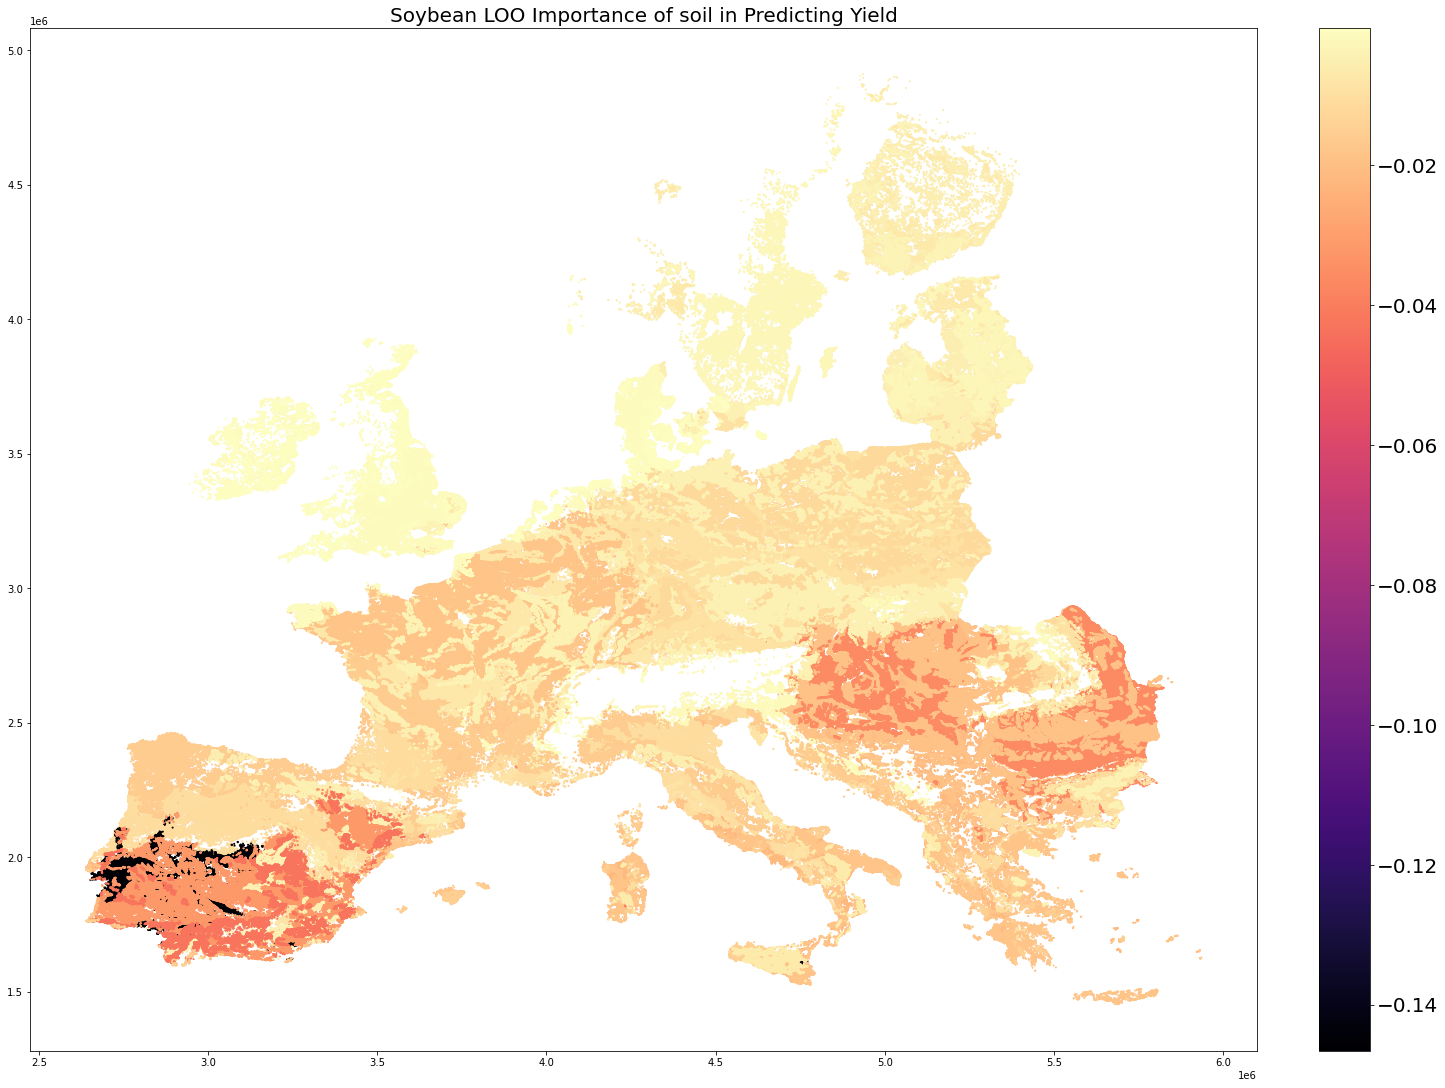

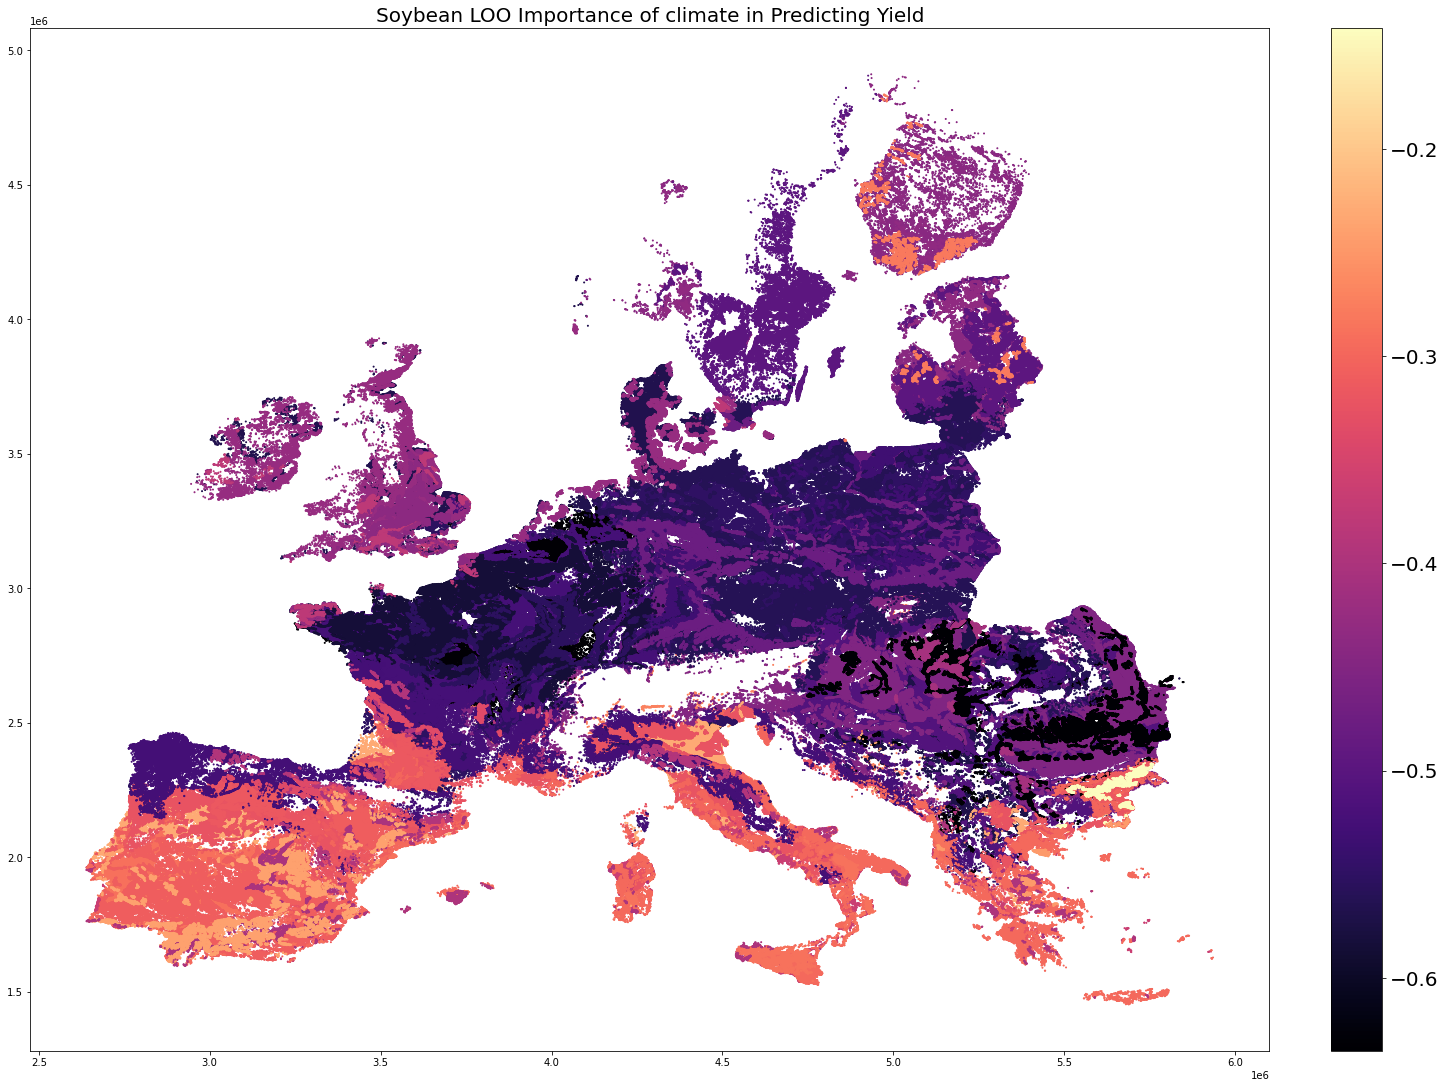

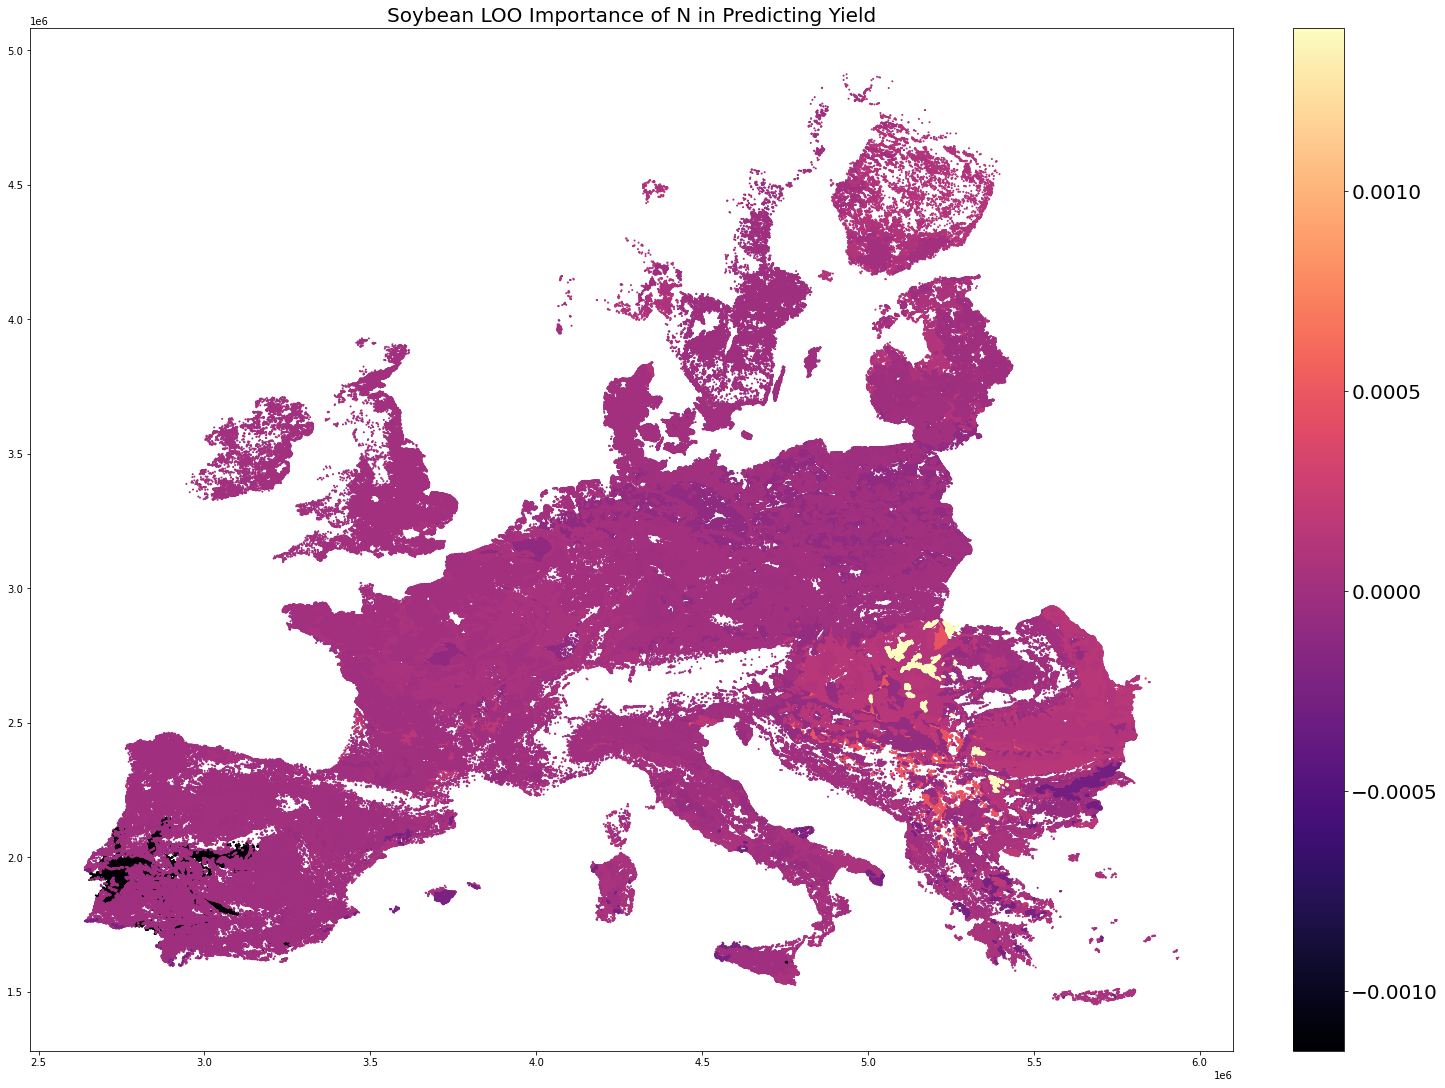

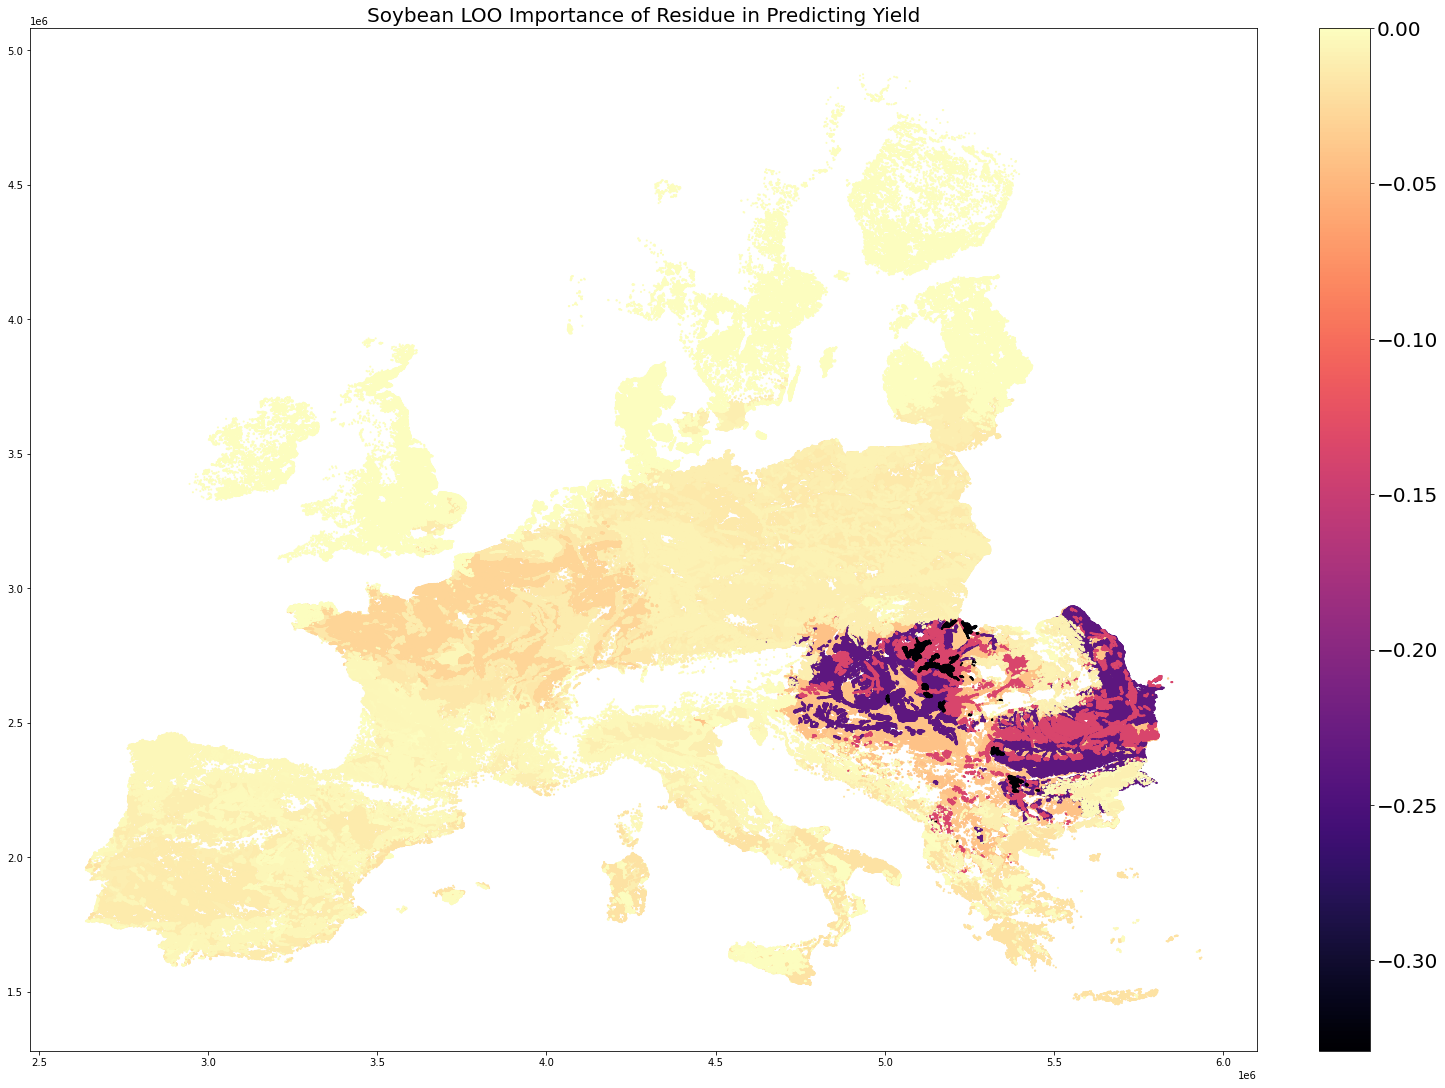

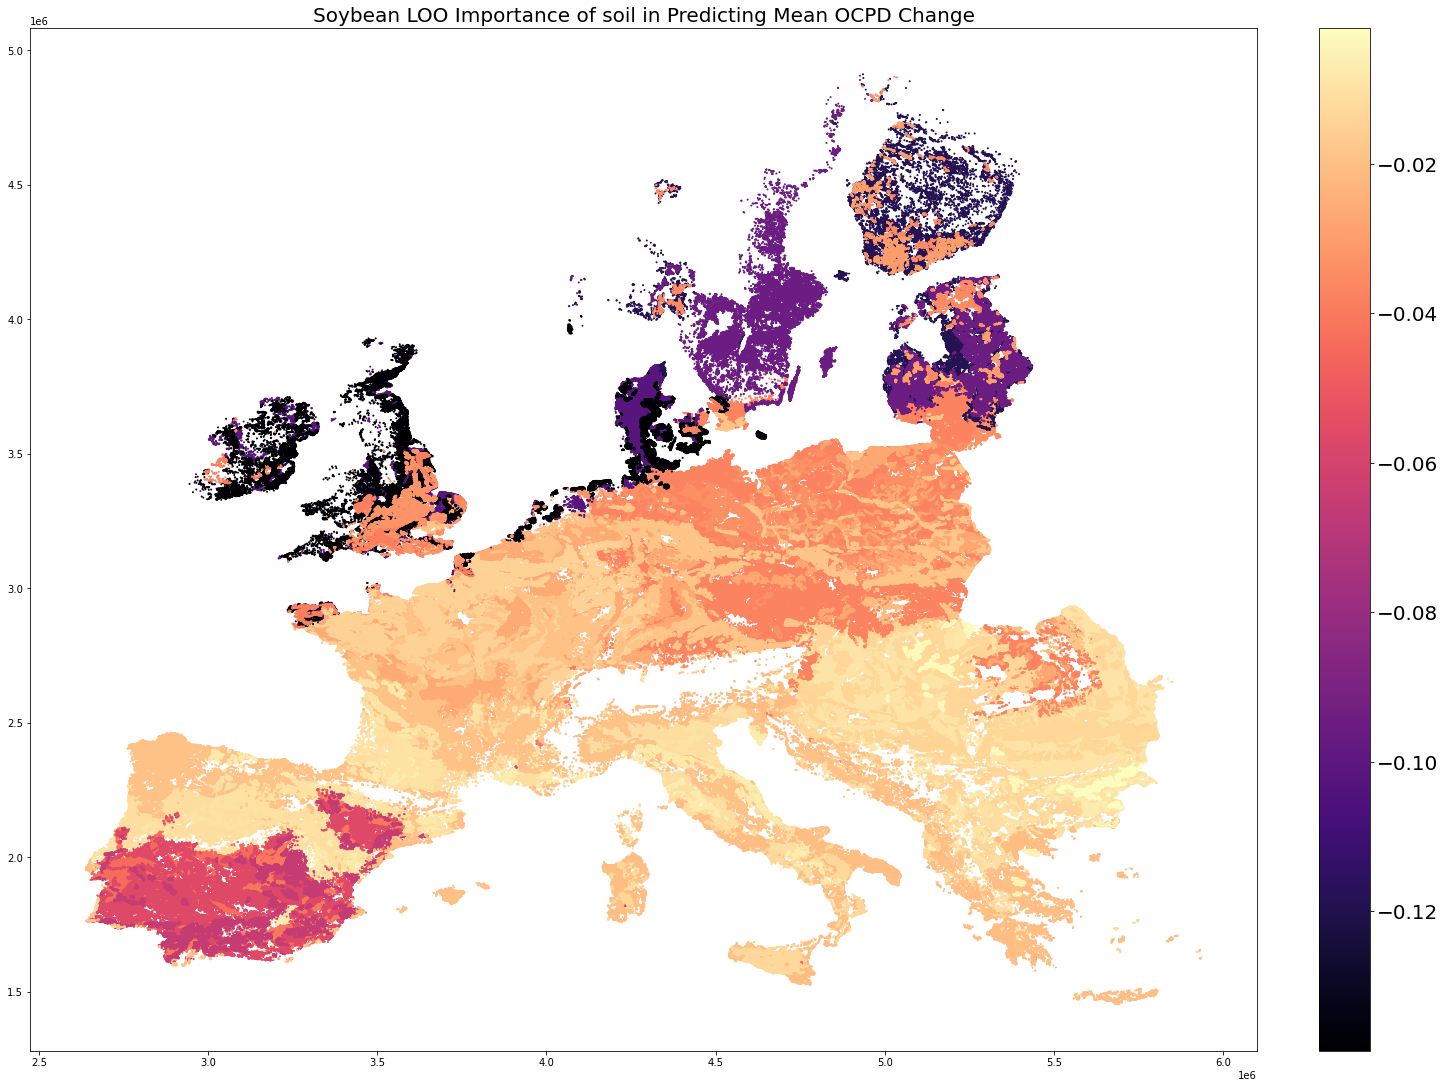

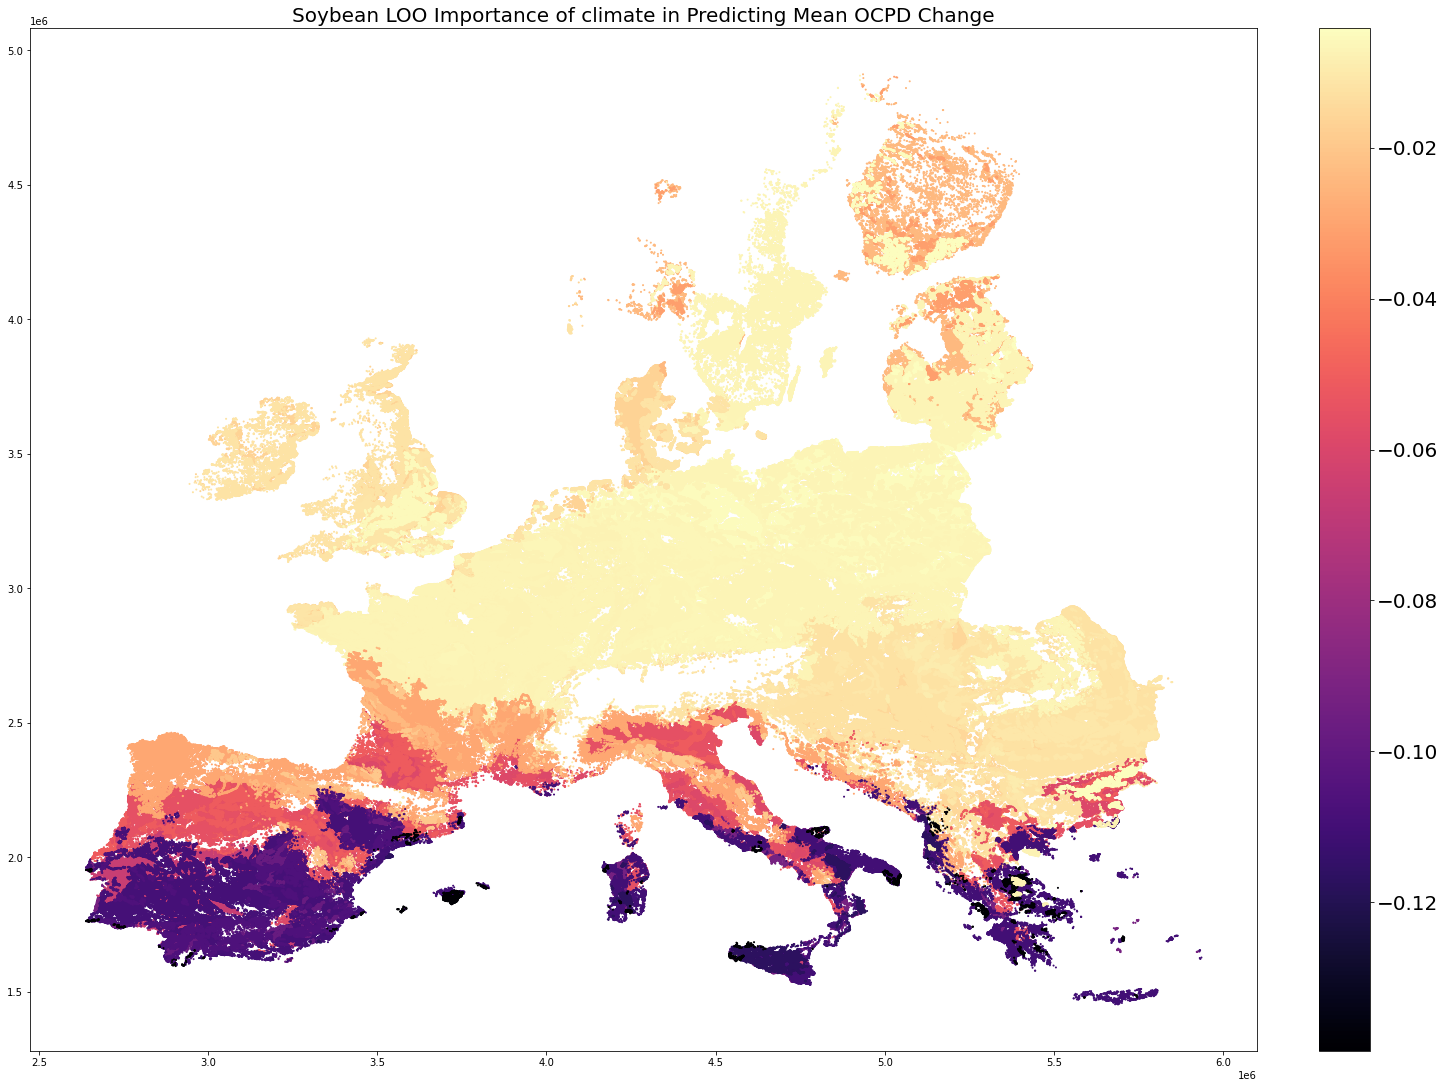

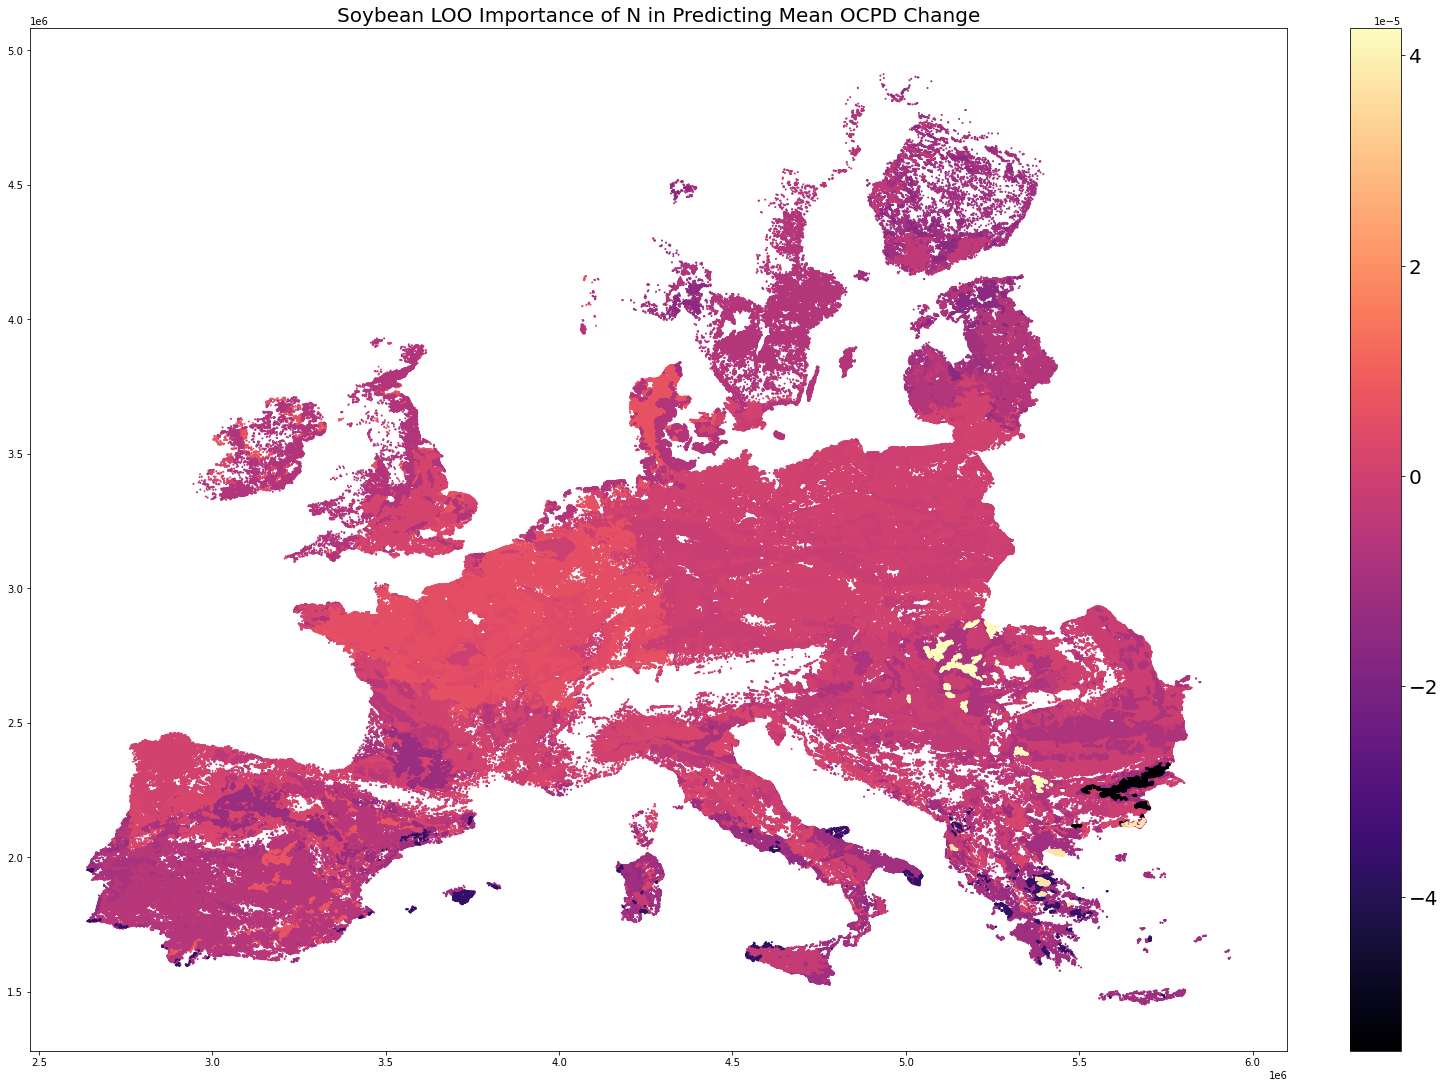

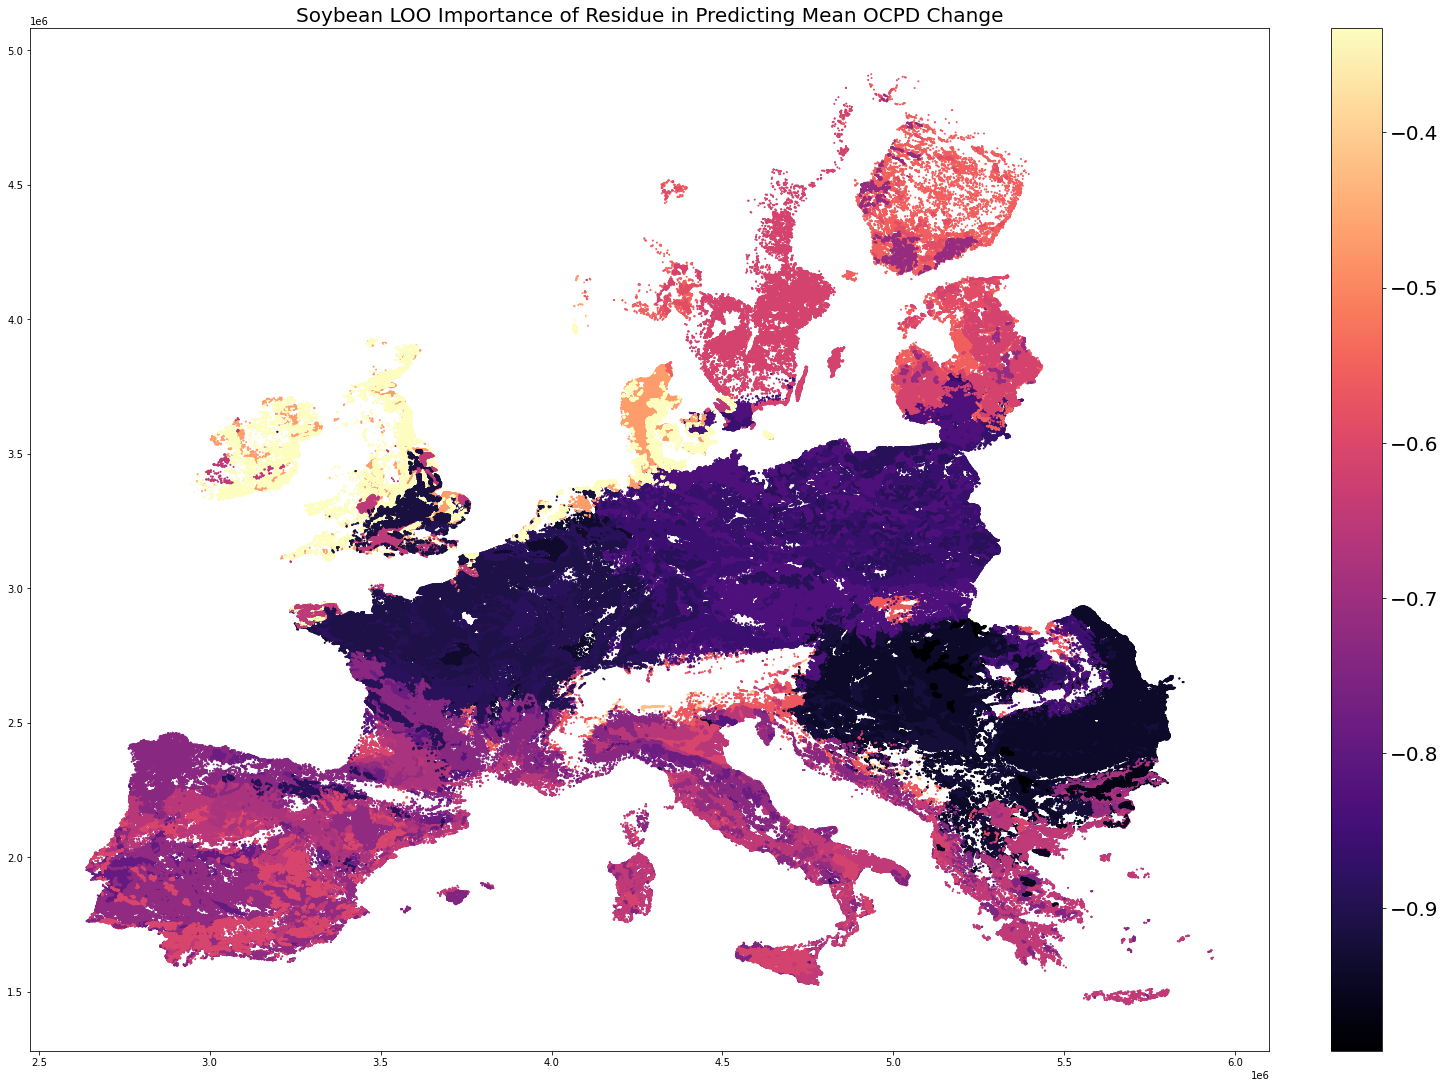

In [17]:
#### INVESTIGATE SCORES AND COEFFICIENTS OF PREDICTORS
for i in range(len(scores_AT)):
    targets = ["Yield", "Mean OCPD Change"]
    t = targets[i]
    scores = scores_AT[i]
    loo_scores = loo_scores_AT[i]
    for v in ['soil', 'climate', 'N', 'Residue']:
        # score df 
        X_loc = []
        y_loc = []
        score_by_loc = []
        coeff_list = []
        loo_for_var = []

        variables = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
                       'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
                       'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std', 'soil', 'climate', 'N', 'Residue']


        # predictor to investigate 
        predictor = v
        predictor_index = variables.index(predictor)

        for c in range(len(cluster_dfs)-1):
            pulled_pts = loc_df[loc_df.SimUID.isin(list(cluster_dfs[c].SimUID.unique()))]
            X_loc.append(pulled_pts['X'])
            y_loc.append(pulled_pts['Y'])
            score_by_loc.append(([scores[c]] * len(pulled_pts)))
            loo_for_var.append(([(loo_scores[c][predictor_index] - scores[c])] * len(pulled_pts)))


        # flatten for plotting
        flat_scores = [x for xs in score_by_loc for x in xs]
        flat_x = [x for xs in X_loc for x in xs]
        flat_y = [x for xs in y_loc for x in xs]
        flat_loo = [x for xs in loo_for_var for x in xs]
        #### MAP PLOTTING
        f = 20

        var_to_plot_label = "LOO Importance of " + v
        # var_to_plot_label = "R Squared"
        var_to_plot = flat_loo
        # var_to_plot = flat_scores


#         All positive values
        colm = cm.get_cmap('magma')
        fig = plt.figure(figsize = (20,15), constrained_layout=True)
        plt.title(("Soybean " + var_to_plot_label + " in Predicting " + t), fontsize = f)
#         plt.scatter(flat_x, flat_y, s = 1, c = var_to_plot, cmap = colm, edgecolor = None, alpha = 1, vmin=-.016, vmax=0)
        plt.scatter(flat_x, flat_y, s = 1, c = flat_loo, cmap = colm, edgecolor = None, alpha = 1)
        plt.grid(False)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=20)
#         plt.show()
        plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SOYB//figures//LOO//"+t.replace(" ", "_") + "_" + var_to_plot_label.replace(" ", "_") + "_map.jpg")